In [1]:
use_gpu = True
data_dir = '/home/victor/data'

In [2]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport alphagan

In [3]:
from collections import defaultdict
from psutil import cpu_count

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import init, Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
cifar = datasets.CIFAR100(
    data_dir,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_transform=None,
    download=False)
cifar = torch.stack(list(zip(*cifar))[0])*2-1
cifar.size()

torch.Size([50000, 3, 32, 32])

In [5]:
cifar_test = datasets.CIFAR100(
    data_dir,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_transform=None,
    download=False)
cifar_test = torch.stack(list(zip(*cifar_test))[0])*2-1
cifar_test.size()                          

torch.Size([10000, 3, 32, 32])

In [6]:
batch_size = 64

In [34]:
n_train, n_test = len(cifar)//1, batch_size*64

num_workers = cpu_count() if use_gpu else 0

train_idxs = torch.LongTensor(np.random.permutation(len(cifar))[:n_train])
X_train = DataLoader(cifar[train_idxs], batch_size=batch_size, shuffle=True,
                     num_workers=num_workers, pin_memory=use_gpu)
test_idxs = torch.LongTensor(np.random.permutation(len(cifar_test))[:n_test])
X_test = DataLoader(cifar_test[test_idxs], batch_size=batch_size, shuffle=False,
                   num_workers=num_workers, pin_memory=use_gpu)

In [35]:
# I think broadcasting should make these unnecessary in the next pytorch release
class ChannelsToLinear(nn.Linear):
    def forward(self, x):
        b = x.size(0)
        return super().forward(x.view(b,-1))
class LinearToChannels(nn.Linear):
    def __init__(self, m, n, w=1, h=None, **kw):
        super().__init__(m, n*w*h, **kw)
        self.w = w
        self.h = h if h else w
    def forward(self, x):
        b = x.size(0)
        return super().forward(x).view(b, -1, self.w, self.h)

# versatile ResNet block which can be upsampling or downsampling
class ResBlock(nn.Module):
    def __init__(self, c,
                 activation=nn.LeakyReLU, norm=nn.BatchNorm2d,
                 upsample=1, downsample=1):
        super().__init__()
        self.a1 = activation()
        self.a2 = activation()
        self.norm1 = norm(c)
        self.norm2 = norm(c)
        
        self.resample=None
        assert upsample==1 or downsample==1
        if upsample>1:
            self.conv1 = nn.ConvTranspose2d(c, c, upsample, upsample, bias=False)
            self.resample = nn.UpsamplingNearest2d(scale_factor=upsample)
        else:
            self.conv1 = nn.Conv2d(c, c, 3, downsample, 1, bias=False)
        if downsample>1:
            self.resample = nn.AvgPool2d(downsample)
            
        self.conv2 = nn.Conv2d(c, c, 3, 1, 1, bias=False)
        
        init.xavier_uniform(self.conv1.weight, 2)
        init.xavier_uniform(self.conv2.weight, 2)
        
    def forward(self, x):
        
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.a1(y)
        y = self.conv2(y)
        y = self.norm2(y)
        
        if self.resample:
            x = self.resample(x)
        
        return self.a2(x+y)

In [36]:
latent_dim = 128

In [37]:
h = 128
pool = nn.AvgPool2d
norm = nn.BatchNorm2d
a = lambda: nn.LeakyReLU(.2)
E = nn.Sequential(
    nn.Conv2d(3,h,3,2,1,bias=False), norm(h), a(),
    ResBlock(h, activation=a, norm=norm, downsample=2),
    ResBlock(h, activation=a, norm=norm),
    ResBlock(h, activation=a, norm=norm),
    a(), pool(8),
    ChannelsToLinear(h, latent_dim)
)

for layer in (E[0], E[8]):
    init.xavier_uniform(layer.weight, 2)

t = Variable(torch.randn(batch_size,3,32,32))
assert E(t).size() == (batch_size,latent_dim)

In [38]:
h = 128
pool = nn.AvgPool2d
norm = nn.BatchNorm2d
a = nn.ReLU#lambda: nn.LeakyReLU(.2)
G = nn.Sequential(
    LinearToChannels(latent_dim, h, 4, 4, bias=False), norm(h), a(),
    ResBlock(h, activation=a, norm=norm, upsample=2),
    ResBlock(h, activation=a, norm=norm, upsample=2),
    ResBlock(h, activation=a, norm=norm, upsample=2),
    nn.Conv2d(h, 3, 1, 1), nn.Tanh()
)

for layer in (G[0], G[6]):
    init.xavier_uniform(layer.weight, 2)

t = Variable(torch.randn(batch_size,latent_dim))
assert G(t).size() == (batch_size,3,32,32)

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


In [39]:
h = 128
pool = nn.AvgPool2d
norm = nn.BatchNorm2d
a = lambda: nn.LeakyReLU(.2)
D = nn.Sequential(
    nn.Conv2d(3,h,3,2,1), norm(h), a(),
    ResBlock(h, activation=a, norm=norm, downsample=2),
    ResBlock(h, activation=a, norm=norm),
    ResBlock(h, activation=a, norm=norm),
    a(), pool(8),
    ChannelsToLinear(h, 1), nn.Sigmoid()
)

for layer in (D[0], D[8]):
    init.xavier_uniform(layer.weight, 2)
    
t = Variable(torch.randn(batch_size,3,32,32))
assert D(t).size() == (batch_size,1)

In [40]:
h = 256
a = lambda: nn.LeakyReLU(.2)
norm = nn.BatchNorm1d
C = nn.Sequential(
    nn.Linear(latent_dim, h), norm(h), a(),
    nn.Linear(h, h), norm(h), a(),
    nn.Linear(h, 1), nn.Sigmoid(),
)

for i,layer in enumerate(C):
    if i%3==0:
        init.xavier_uniform(layer.weight, 2)

t = Variable(torch.randn(batch_size,latent_dim))
assert C(t).size() == (batch_size,1)

In [41]:
model = alphagan.AlphaGAN(E, G, D, C, latent_dim, lambd=4)
if use_gpu:
    model = model.cuda()

In [42]:
# model.load_state_dict(torch.load('../models/cifar100_lambda_10_epochs_20.torch'))

In [43]:
diag = []
def log_fn(d):
    d = pd.DataFrame(d)
    diag.append(d)
    print(d)
def checkpoint_fn(model, epoch):
    path =  '../models/cifar100_dim_{}_lambda_{}_epochs_{}.torch'.format(
        model.latent_dim, model.lambd, epoch
    )
    torch.save(model.state_dict(), path)

In [44]:
model.fit(
    X_train, X_test,
    n_iter=(1,2), n_epochs=20,
    log_fn=log_fn, log_every=1,
    checkpoint_fn=checkpoint_fn, checkpoint_every=4
)

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


                            train     valid
adversarial_loss         0.863087  0.812966
code_adversarial_loss    0.647430  0.707427
code_discriminator_loss  1.488145  1.291224
discriminator_loss       1.197396  1.333861
reconstruction_loss      1.171977  1.204495


                            train     valid
adversarial_loss         0.864622  0.864204
code_adversarial_loss    0.701094  0.704887
code_discriminator_loss  1.387093  1.346067
discriminator_loss       1.207188  1.319075
reconstruction_loss      1.069393  1.118818


                            train     valid
adversarial_loss         0.899637  1.079925
code_adversarial_loss    0.709791  0.719388
code_discriminator_loss  1.370568  1.375582
discriminator_loss       1.196083  1.303975
reconstruction_loss      1.045846  1.086437


                            train     valid
adversarial_loss         0.909864  0.864136
code_adversarial_loss    0.715603  0.748939
code_discriminator_loss  1.360583  1.270216
discriminator_loss       1.188783  1.346283
reconstruction_loss      1.030697  1.158050


                            train     valid
adversarial_loss         0.925299  0.732703
code_adversarial_loss    0.718316  0.745222
code_discriminator_loss  1.355639  1.377067
discriminator_loss       1.178590  1.335861
reconstruction_loss      1.027676  0.962834


                            train     valid
adversarial_loss         0.936734  0.623642
code_adversarial_loss    0.721820  0.753584
code_discriminator_loss  1.351713  1.388412
discriminator_loss       1.189174  1.341959
reconstruction_loss      1.027158  1.174762


                            train     valid
adversarial_loss         0.975422  0.851468
code_adversarial_loss    0.729302  0.753036
code_discriminator_loss  1.341079  1.372127
discriminator_loss       1.158443  1.378842
reconstruction_loss      1.045319  1.170917


                            train     valid
adversarial_loss         1.012218  0.950375
code_adversarial_loss    0.735432  0.772308
code_discriminator_loss  1.334677  1.355484
discriminator_loss       1.158174  1.396513
reconstruction_loss      1.069230  1.126402


                            train     valid
adversarial_loss         0.998414  0.937258
code_adversarial_loss    0.740559  0.745471
code_discriminator_loss  1.329010  1.517536
discriminator_loss       1.176693  1.380528
reconstruction_loss      1.074479  1.241337


                            train     valid
adversarial_loss         1.011052  0.799542
code_adversarial_loss    0.743556  0.775730
code_discriminator_loss  1.326600  1.458685
discriminator_loss       1.176006  1.381323
reconstruction_loss      1.080060  1.207780


                            train     valid
adversarial_loss         1.031107  0.821105
code_adversarial_loss    0.743522  0.767286
code_discriminator_loss  1.329758  1.610483
discriminator_loss       1.148702  1.297803
reconstruction_loss      1.082514  1.249089


                            train     valid
adversarial_loss         1.019434  0.955711
code_adversarial_loss    0.746674  0.752706
code_discriminator_loss  1.325128  1.570013
discriminator_loss       1.171409  1.451453
reconstruction_loss      1.092801  1.221556


                            train     valid
adversarial_loss         1.027305  0.984432
code_adversarial_loss    0.752197  0.733120
code_discriminator_loss  1.319097  1.534416
discriminator_loss       1.154379  1.400115
reconstruction_loss      1.092287  1.192557


                            train     valid
adversarial_loss         1.034711  0.948175
code_adversarial_loss    0.753977  0.725740
code_discriminator_loss  1.318322  1.616301
discriminator_loss       1.142924  1.428077
reconstruction_loss      1.085488  1.311627


                            train     valid
adversarial_loss         1.005763  0.807630
code_adversarial_loss    0.752722  0.831821
code_discriminator_loss  1.323110  1.532621
discriminator_loss       1.203685  1.400889
reconstruction_loss      1.099567  1.173358


                            train     valid
adversarial_loss         1.021442  0.793170
code_adversarial_loss    0.755643  0.756548
code_discriminator_loss  1.320451  1.862617
discriminator_loss       1.163093  1.362310
reconstruction_loss      1.096169  1.220747


                            train     valid
adversarial_loss         1.038645  0.826280
code_adversarial_loss    0.756197  0.766862
code_discriminator_loss  1.322507  1.604026
discriminator_loss       1.155757  1.350988
reconstruction_loss      1.102343  1.219484


                            train     valid
adversarial_loss         1.063927  0.920451
code_adversarial_loss    0.766849  0.735417
code_discriminator_loss  1.306180  1.677701
discriminator_loss       1.135034  1.374902
reconstruction_loss      1.115968  1.195598


                            train     valid
adversarial_loss         1.054762  0.787987
code_adversarial_loss    0.769526  0.841105
code_discriminator_loss  1.304173  1.587624
discriminator_loss       1.156131  1.378201
reconstruction_loss      1.138986  1.234398


                            train     valid
adversarial_loss         1.062940  0.843191
code_adversarial_loss    0.770211  0.784671
code_discriminator_loss  1.306112  1.798693
discriminator_loss       1.135141  1.394446
reconstruction_loss      1.139533  1.202213



In [45]:
# torch.save(model.state_dict(), '../models/cifar100_lambda_50_epochs_30.torch')

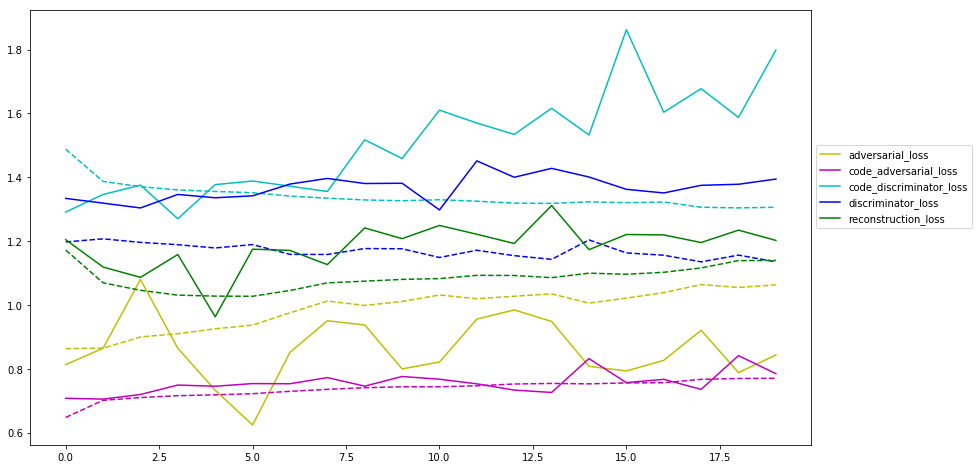

In [46]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
diagnostic = pd.concat([pd.DataFrame(d.stack(), columns=[i]).T for i,d in enumerate(diag)])
cols = list('rgbcmy')
colors = defaultdict(lambda: cols.pop())
for c in diagnostic:
    component, dataset = c
    kw = {}
    if dataset=='valid':
        kw['label'] = component
    else:
        kw['ls'] = '--'
    ax.plot(diagnostic[c].values, c=colors[component], **kw)
ax.legend(bbox_to_anchor=(1, 0.7))

In [47]:
model.eval()
pass

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


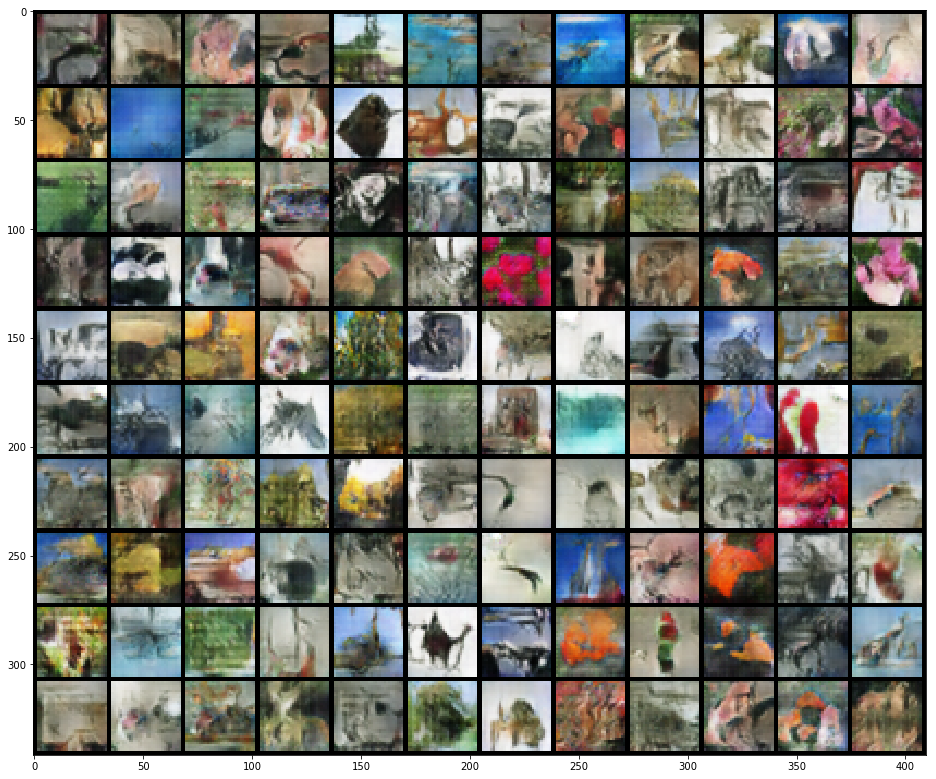

In [48]:
# samples
z, x = model(120, mode='sample')
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(make_grid(
    x.data, nrow=12, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


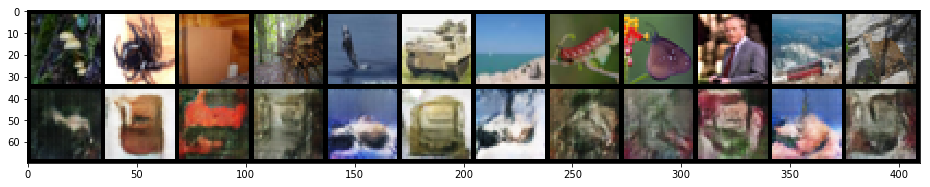

In [49]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# training reconstructions
x = cifar[train_idxs][:12]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=12, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


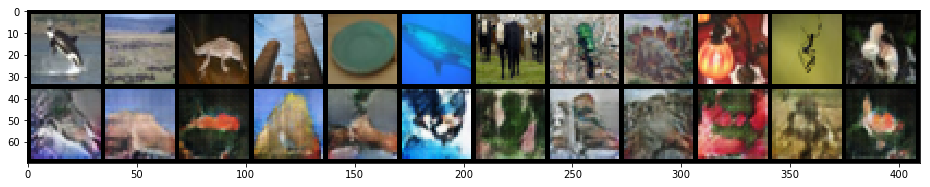

In [50]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# test reconstructions
x = cifar_test[test_idxs][:12]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=12, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

the encoder seems to populate a smaller region of the latent space than the prior does (see below). This is exacerbated for higher lambda. It also seems to get worse with extra generator steps. But even with moderate lambda (8-10) and double generator steps, the effect is substantial and so consistent as to suggest a bug.

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


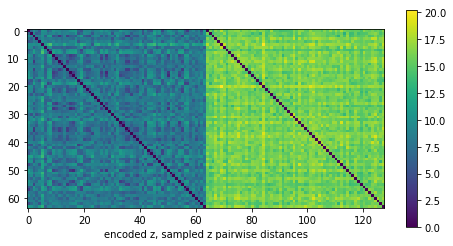

In [51]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

import scipy.spatial
x = cifar_test[test_idxs][:64]
z, x_rec = model(x)
encoded = z.data.cpu().numpy()
sampled = model.sample_prior(len(z)).data.cpu().numpy()
encoded_cdist = scipy.spatial.distance.cdist(encoded,encoded)
sampled_cdist = scipy.spatial.distance.cdist(sampled,sampled)
cax = ax.imshow(np.concatenate((encoded_cdist, sampled_cdist),1))
fig.colorbar(cax)
ax.set_xlabel('encoded z, sampled z pairwise distances')
pass